In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mpld3
import statsmodels.api as sm

In [2]:
filename = "data/CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals.csv"
df = pd.read_csv(filename)

In [3]:
# check for missing data, if any
if df.isna().values.sum():
    df.dropna(inplace=True)

In [4]:
# change date to datetime format
df['datetime'] = pd.to_datetime(df['date'], format='%m/%d/%Y')

In [5]:
df['rides'] = df.groupby(['stationname','datetime'])['rides'].mean().reset_index()['rides']

In [6]:
# extract season, day of week, month, year
seasons = ['Winter','Winter','Spring','Spring','Spring','Summer',
           'Summer','Summer','Fall','Fall','Fall','Winter']
months = range(1,13)
mtos = dict(zip(months,seasons))
df['season'] = df['datetime'].dt.month.map(mtos)
df['weekday']=df['datetime'].dt.dayofweek.map({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday',
                                              4:'Friday', 5:'Saturday', 6:'Sunday'})
df['month']=pd.DatetimeIndex(df['datetime']).month
df['year']=pd.DatetimeIndex(df['datetime']).year

In [7]:
daytypes = df.daytype.unique().tolist()
daytypedict = dict(zip(daytypes, ['Sun/Hol', 'Weekday', 'Sat']))
df['daytype']=df['daytype'].map(daytypedict)

In [8]:
stations = df.stationname.unique().tolist()
mparklist = ['Washington/Wabash', 'Clark/Lake']

In [9]:
# checking out when stations were closed
count_days = df.groupby('stationname')['rides'].count().reset_index()
day_count_stats = count_days.describe().loc['25%','rides']
count_days[count_days['rides'] < day_count_stats].sort_values(by='rides').reset_index(drop=True).loc[0:9]

,stationname,rides
0,Homan,31
1,Washington/Wabash,330
2,Cermak-McCormick Place,1273
3,Morgan-Lake,2248
4,Dempster-Skokie,2277
5,Oakton-Skokie,2278
6,Washington/State,2953
7,Skokie,4111
8,Madison/Wabash,6216
9,Conservatory,6235


In [10]:
# find trends in ridership (from 2012 to 2017 years)
years_list = np.arange(2017, 2011, -5)
df_diff = df[df['year'].isin(years_list)]
df_diff = df_diff.groupby(['stationname','year'])['rides'].mean().reset_index()

# get rid of stations w/ missing data in 2012 or 2017
df_diff = df_diff.groupby('stationname').filter(lambda x: len(x) >1)

# find change in ridership in past 5 years
df_diff['5yr_diff'] = df_diff['rides'].diff()
df_diff['5yr_percent_diff'] = df_diff['rides'].pct_change()
df_diff = df_diff[df_diff['year']!= 2012]

In [11]:
# get 25 stations with biggest ridership change from 5 years ago
topdiffs = df_diff.sort_values(by=['5yr_diff'], ascending=False).reset_index(drop=True).loc[0:24,:]
topprops = df_diff.sort_values(by=['5yr_percent_diff'], ascending=False).reset_index(drop=True).loc[0:24,:]
top = topdiffs[topdiffs['stationname'].isin(topprops['stationname'])]
topstationlist = top.stationname.unique()

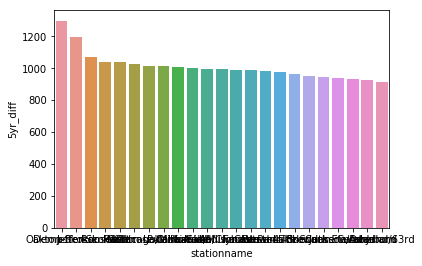

In [12]:
sns.barplot(x='stationname', y='5yr_diff', data=top)

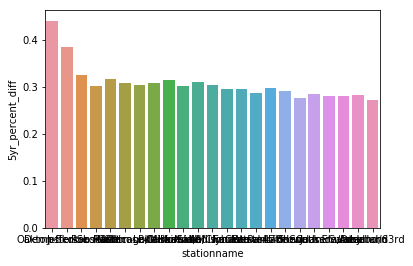

In [13]:
sns.barplot(x='stationname', y='5yr_percent_diff', data=top)

In [14]:
# now get an average change rate over the past 5 years
df_yrdiff=pd.DataFrame()
years_list_5 = np.arange(2017, 2011, -1)
df_yrdiff = df[df['year'].isin(years_list_5)]
df_yrdiff = df_yrdiff.groupby(['stationname','year'])['rides'].mean().reset_index()

# get rid of stations w/ missing data in 2012 or 2017
df_yrdiff = df_yrdiff.groupby('stationname').filter(lambda x: len(x) >5)

# # find change in ridership in past 5 years
df_yrdiff['5yr_diff_ave'] = df_yrdiff['rides'].diff()
df_yrdiff['5yr_percent_diff_ave'] = df_yrdiff['rides'].pct_change()
df_yrdiff = df_yrdiff[df_yrdiff['year']!= 2012]
df_yrdiff=df_yrdiff.groupby('stationname').mean().reset_index()
df_yrdiff['years']=str(years_list_5[0])+'-'+str(years_list_5[-1])

In [15]:
# get 25 stations with biggest ridership change from 5 years ago
topdiffs_ave = df_yrdiff.sort_values(by=['5yr_diff_ave'], ascending=False).reset_index(drop=True).loc[0:24,:]
topprops_ave = df_yrdiff.sort_values(by=['5yr_percent_diff_ave'], ascending=False).reset_index(drop=True).loc[0:24,:]
top_ave = topdiffs_ave[topdiffs_ave['stationname'].isin(topprops['stationname'])]
topstationlist_ave = top_ave.stationname.unique()

In [16]:
df['is_topstation_ave']=df['stationname'].isin(topstationlist_ave)

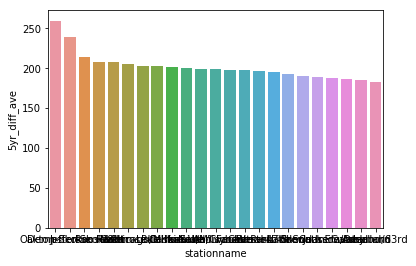

In [17]:
sns.barplot(x='stationname', y='5yr_diff_ave', data=top_ave)

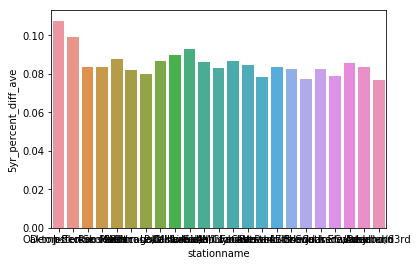

In [18]:
sns.barplot(x='stationname', y='5yr_percent_diff_ave', data=top_ave)

In [19]:
# plot ridership over time
def make_time_plot(df, station):    
    d = df[df['stationname']==station]
    x = 'datetime'
    y = 'rides'
    a=d[x]
    b=d[y]
    fig, ax = plt.subplots()
    ax.plot(a, b)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.title(station)

/Users/djb326/.pyenv/versions/3.6.7/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


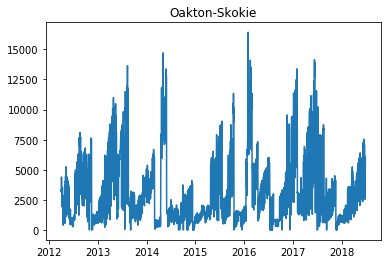

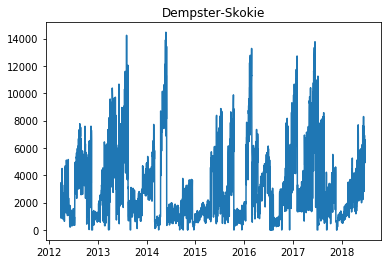

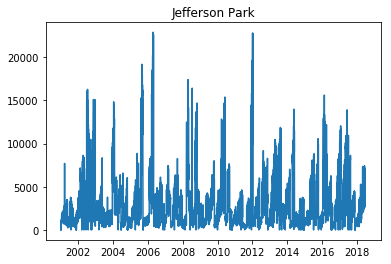

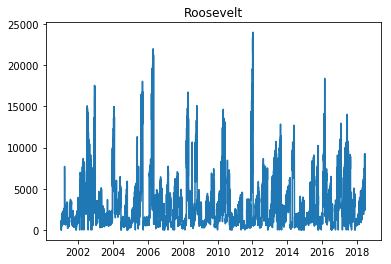

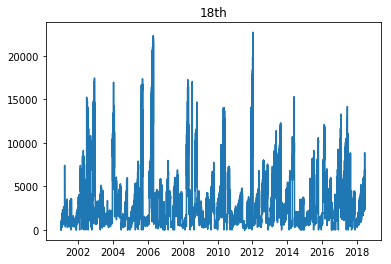

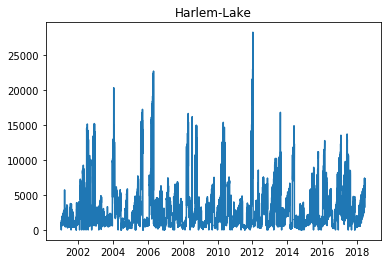

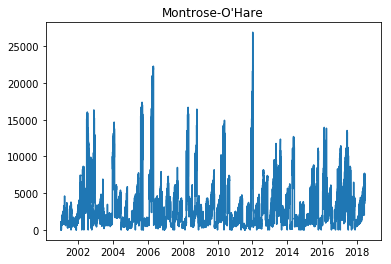

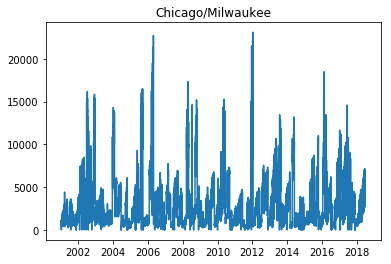

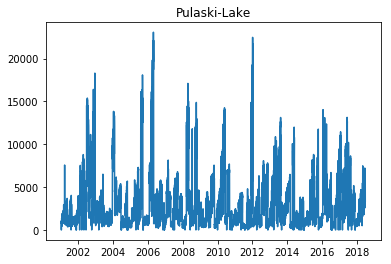

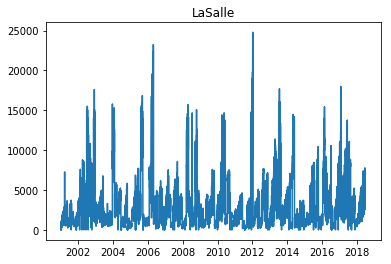

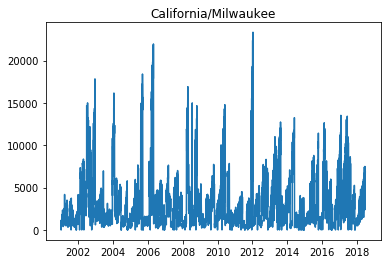

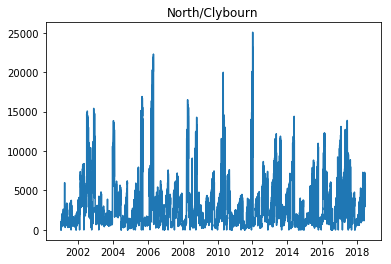

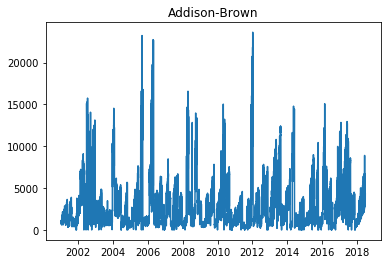

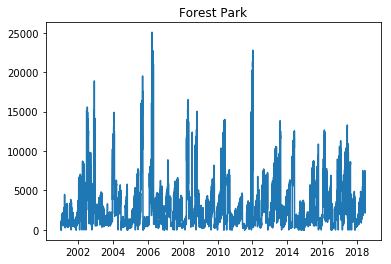

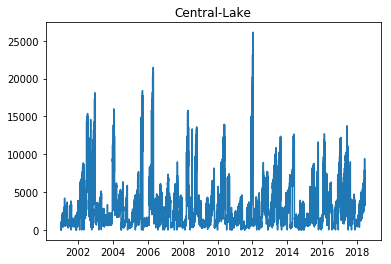

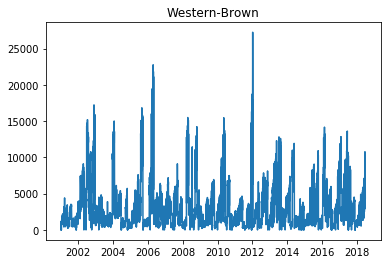

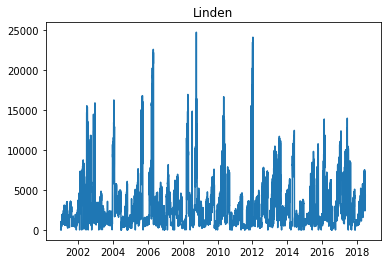

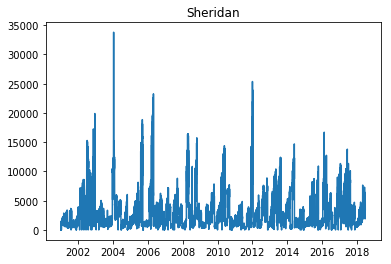

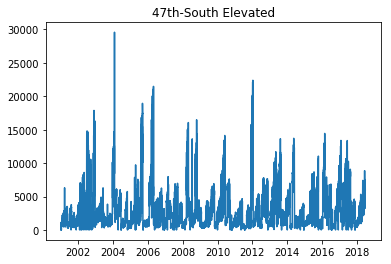

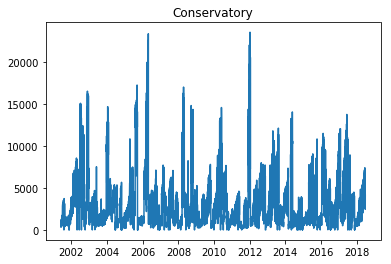

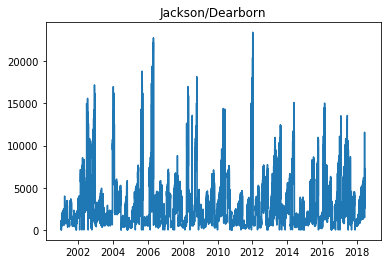

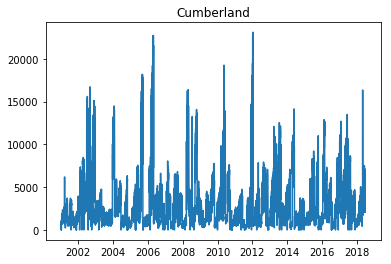

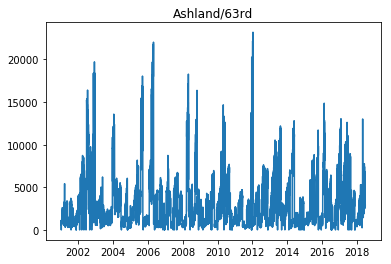

In [20]:
# plots stations with big changes from 2012 to 2017
for stat in topstationlist:
    make_time_plot(df, stat)

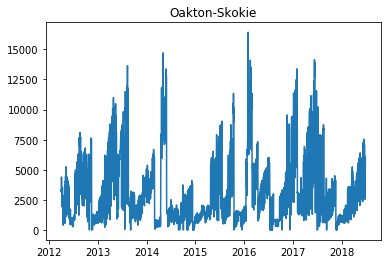

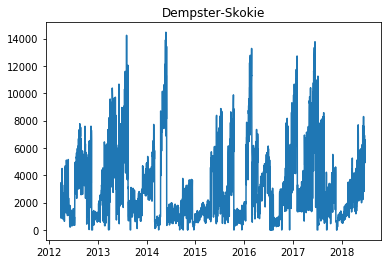

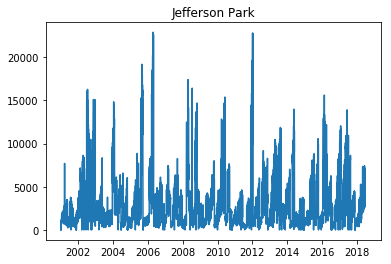

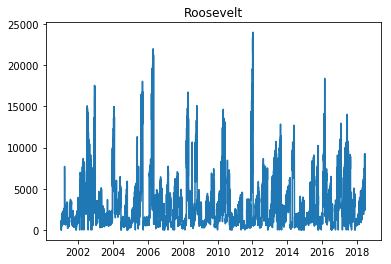

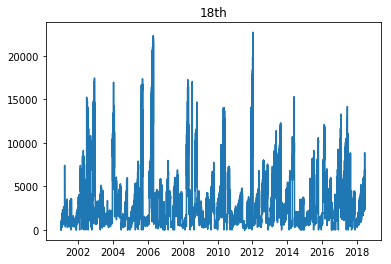

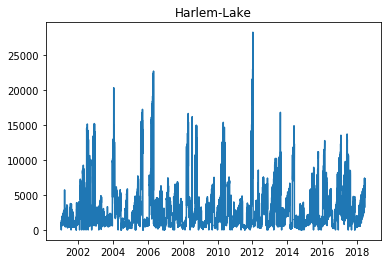

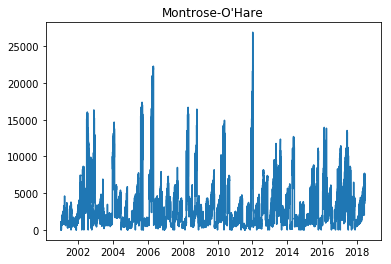

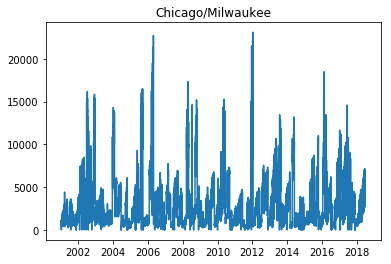

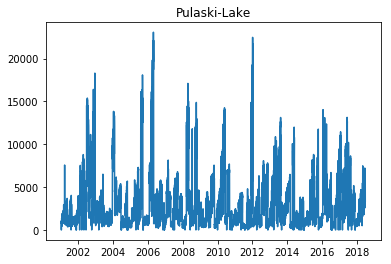

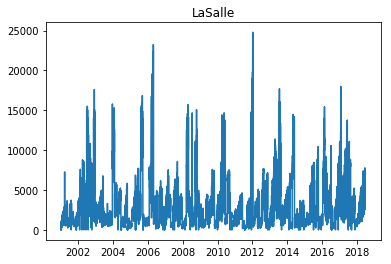

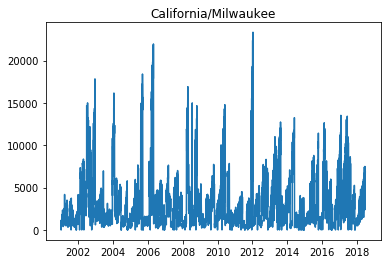

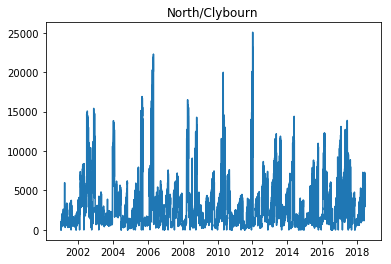

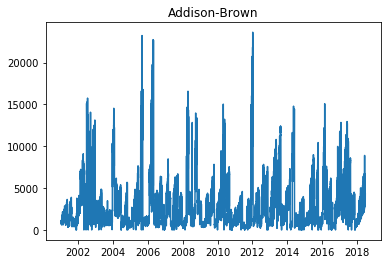

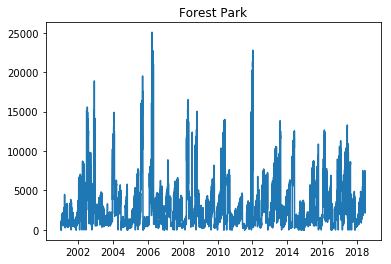

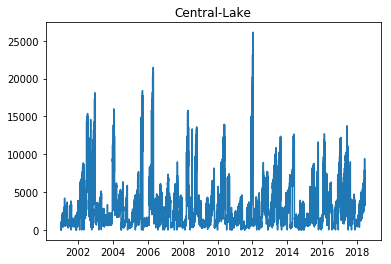

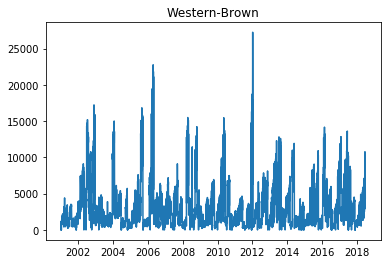

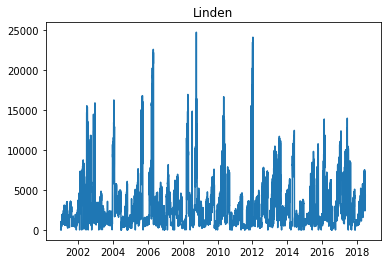

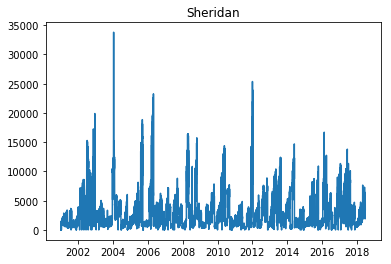

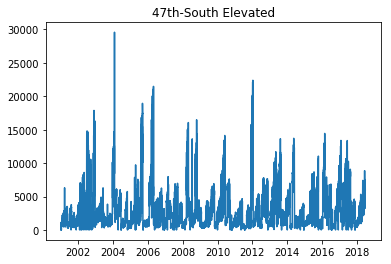

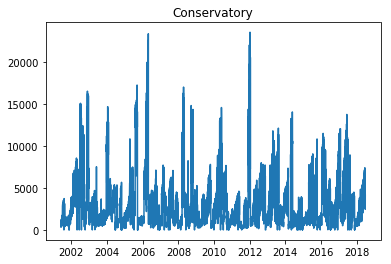

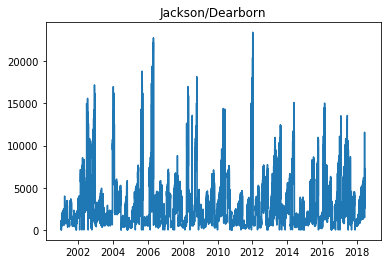

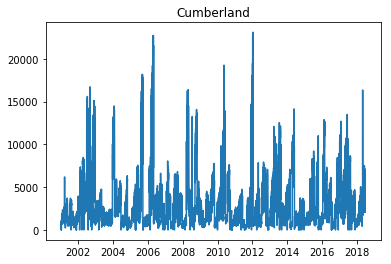

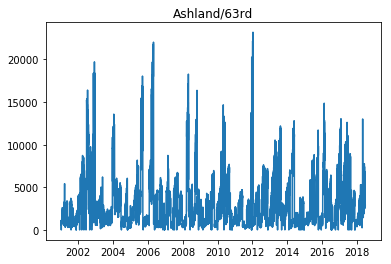

In [21]:
# plots stations with greatest average yearly increases between 2012 and 2017
for stat in topstationlist_ave:
    make_time_plot(df, stat)

In [22]:
def make_layered_hist(array, station, variablename, variablelist):
    fig, ax = plt.subplots()
    for var in variablelist:
        condarray = array[(array['stationname']==station) & (array[variablename]==var)]
        dist=sns.distplot(condarray['rides'], ax=ax, label=var)
        ax.legend()
        ax.set_xlabel('# of Rides Daily', fontsize=16)
    dist=dist.get_figure()
    ax.set_ylabel('Frequency', fontsize=16)
    ax.set_xlim([0,25000])
    plt.title('Distribution of ' + station +' Rides', fontsize=20)
    return fig, ax
    dist.savefig('figs/react_kde' + condDay + '.png')
    plt.clf()

In [ ]:
y=pd.DataFrame(df.groupby(by=['stationname'])['rides'].mean())
y.loc[y.idxmax()]

In [ ]:
stds = pd.DataFrame(index=stations, columns=['std'])
for station in stations:
    stds.loc[station,'std'] = (df.rides[df['stationname']==station].std())
plt.plot(stds)    

In [24]:
df_map = pd.read_csv('data/CTA_-_System_Information_-_List_of__L__Stops.csv')

In [25]:
loc_string = df_map[df_map['STATION_NAME']=='Morse'].reset_index().loc[0,'Location']

In [26]:
lat,long = loc_string.strip('()').split(',')

In [27]:
lats = []
lons = []
for val in df_map.Location:
    lat, long = val.strip('()').split(',')
    lats.append(float(lat))
    lons.append(float(long))
df_map['latitude']=lats  
df_map['longitude']=lons  

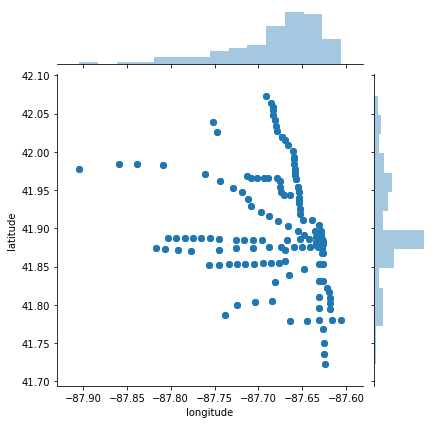

In [28]:
sns.jointplot(x="longitude",y="latitude", data=df_map)

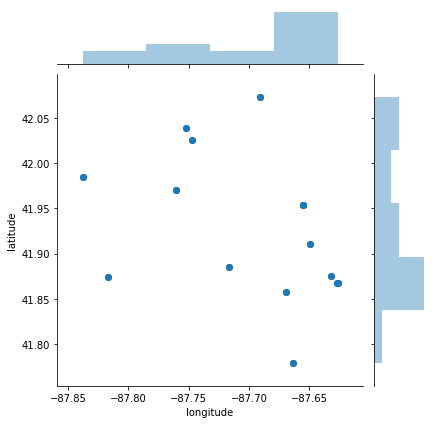

In [29]:
top_map = df_map[df_map['STATION_NAME'].isin(topstationlist)]
top_map.shape
sns.jointplot(x="longitude",y="latitude", data=top_map)

In [30]:
top_rides = top.set_index('stationname')
top_map = top_map.set_index('STATION_NAME')
top_ave_rides = top_ave.set_index('stationname')

In [31]:
all_top = top_map.join(top_ave_rides, how='outer')

In [32]:
all_top.index.tolist()

['18th',
 '18th',
 '47th-South Elevated',
 'Addison-Brown',
 'Ashland/63rd',
 'Ashland/63rd',
 'California/Milwaukee',
 'Central-Lake',
 'Chicago/Milwaukee',
 'Conservatory',
 'Conservatory',
 'Cumberland',
 'Cumberland',
 'Dempster-Skokie',
 'Dempster-Skokie',
 'Forest Park',
 'Forest Park',
 'Harlem-Lake',
 'Jackson/Dearborn',
 'Jefferson Park',
 'Jefferson Park',
 'LaSalle',
 'LaSalle',
 'Linden',
 'Linden',
 "Montrose-O'Hare",
 'North/Clybourn',
 'North/Clybourn',
 'Oakton-Skokie',
 'Oakton-Skokie',
 'Pulaski-Lake',
 'Roosevelt',
 'Roosevelt',
 'Roosevelt',
 'Roosevelt',
 'Sheridan',
 'Sheridan',
 'Sheridan',
 'Sheridan',
 'Western-Brown']

In [33]:
import mpld3

fig, ax = plt.subplots(subplot_kw=dict(facecolor='#EEEEEE'))

scatter = ax.scatter(np.array(all_top.longitude, dtype=float),
                     np.array(all_top.latitude, dtype=float),
                     c=np.random.random(size=len(all_top.latitude)),
                     s=np.array(5000 * all_top['5yr_percent_diff_ave'] , dtype=float),
                     alpha=0.3,
                     cmap=plt.cm.jet)
ax.grid(color='white', linestyle='solid')
ax.set_xlim([-87.9,-87.6])
ax.set_ylim([41.7,42.1])
ax.set_title("Scatter Plot (with tooltips!)", size=20)

labels = all_top.index.tolist()
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()